In [1]:
include("../src/CoherentStructures.jl") #this is terrible but neccessary during development (?)

Main.CoherentStructures

In [2]:
using StreamMacros, Main.CoherentStructures
using Tensors, Arpack, JLD2, OrdinaryDiffEq
using Plots, UnicodePlots
using OrdinaryDiffEq, Interpolations

In [3]:
JLD2.@load("Ocean_geostrophic_velocity.jld2");
UV = interpolateVF(Lon, Lat, Time, UT, VT);

In [4]:
# Parameters
quadrature_order       = 1
grid_resolution        = 100
t_initial              = minimum(Time)
t_end                  = t_initial+80     # parameter value corresponding to ϵ=0 (t_max is 90)
wind_scale             = 1e-5
wind_center            = 30;

In [5]:
lattitude_range = range(minimum(Lat),maximum(Lat),length=size(UT)[2]) # should be equal to Lat, but just to be safe
wind_u = repeat(collect(wind_scale.*(lattitude_range.-wind_center))',size(UT)[1],1,size(UT)[3])
wind_v = zero(VT); #no northward component of wind
wind = interpolateVF(Lon, Lat, Time, wind_u, wind_v);

In [6]:
LL, UR = (-4.0, -34.0), (6.0, -28.0)
ctx, _ = regularTriangularGrid((grid_resolution, Integer(floor((UR[2] - LL[2])/(UR[1] - LL[1])*grid_resolution))), 
        LL, UR, quadrature_order = quadrature_order);

In [7]:
function evaluate_on_grid(f,ctx)
    [f(node.x) for node in ctx.grid.nodes]
end

evaluate_on_grid (generic function with 1 method)

In [8]:
function l2_error(reference,solution)
    sum(sum([(a .- b).^2 for (a,b) in zip(reference,solution)])) / length(reference)
end

l2_error (generic function with 1 method)

In [9]:
function linfty_error(reference,solution)
    sum(maximum([(a .- b).^2 for (a,b) in zip(reference,solution)]))
end

linfty_error (generic function with 1 method)

In [10]:
variational_equation = OrdinaryDiffEq.ODEFunction{false}(
    (u,p,t) ->  
    vcat(p[1](u[1],u[2],t) .+ p[3].*p[2](u[1],u[2],t), 
    hcat(p[4](u[1],u[2],t)...) * u[3:4] .+ p[5](u[1],u[2],t))
);

In [11]:
dUV(x,y,t) = Interpolations.gradient(UV,x,y,t)[1:2]
dParam = wind                                        # very handy here

function Tdot_vareq(solver, tolerance, param)
    return x -> 
    flow(variational_equation, vcat(x,0,0), [t_initial, t_end]; 
        p=(UV, wind, param, dUV, dParam), tolerance=tolerance, solver=solver)[end][3:4]
end

Tdot_vareq (generic function with 1 method)

In [12]:
interp_rhs_scaled = OrdinaryDiffEq.ODEFunction{false}((u,p,t) -> p[1](u[1],u[2],t) .+ p[3].*p[2](u[1],u[2],t));

In [13]:
function T(solver, stepsize)
    return (x, param) -> flow(interp_rhs_scaled, x, [t_initial, t_end]; 
                p=(UV, wind, param), dt=stepsize, adaptive=true, solver=solver)[end]
end

T (generic function with 1 method)

In [14]:
function Tdot_autodiff(solver, stepsize, param)
    return x -> Main.CoherentStructures.parameter_autodiff(T(solver, stepsize), x, param)
end

Tdot_autodiff (generic function with 1 method)

In [15]:
function Tdot_finite_differences(solver, stepsize, param, diff)
    return x -> 
     (T(solver, stepsize)(x, param+diff) .- T(solver, stepsize)(x, param-diff)) ./ (2*diff)
end

Tdot_finite_differences (generic function with 1 method)

In [16]:
reference = evaluate_on_grid(Tdot_vareq(OrdinaryDiffEq.BS5(),1e-15,0),ctx);

In [17]:
tolerance_range = [1e-4,1e-5,1e-6,1e-7,1e-8,1e-9,1e-10,1e-11];

In [18]:
autodiff_BS5    = [evaluate_on_grid(Tdot_autodiff(OrdinaryDiffEq.BS5(),tol,0),ctx) 
    for tol in tolerance_range]
vareq_BS5       = [evaluate_on_grid(Tdot_vareq(OrdinaryDiffEq.BS5(),tol,0),ctx)    
    for tol in tolerance_range]
FD_1eminus4_BS5 = [evaluate_on_grid(Tdot_finite_differences(OrdinaryDiffEq.BS5(),tol,0,1e-4),ctx) 
    for tol in tolerance_range]
FD_1eminus3_BS5 = [evaluate_on_grid(Tdot_finite_differences(OrdinaryDiffEq.BS5(),tol,0,1e-3),ctx)
    for tol in tolerance_range]
FD_1eminus5_BS5 = [evaluate_on_grid(Tdot_finite_differences(OrdinaryDiffEq.BS5(),tol,0,1e-5),ctx)
    for tol in tolerance_range];

┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Us

┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Us

┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Us

┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Us

┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Us

┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Us

┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Us

┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Us

┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Us

┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Us

┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Us

┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Us

┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Us

┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Us

┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Us

┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Us

┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Us

┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Us

┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Us

┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Us

┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Us

┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Us

┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Us

┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Us

┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Us

┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Us

┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Us

┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Us

┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Us

┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Us

┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Us

┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Us

┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Us

┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Us

┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Us

┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Us

┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Us

┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Us

┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Us

┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Us

┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Us

┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Us

┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Us

┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Us

┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Us

┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Us

┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Us

┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Us

┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Us

┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Us

Excessive output truncated after 524505 bytes.┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the 

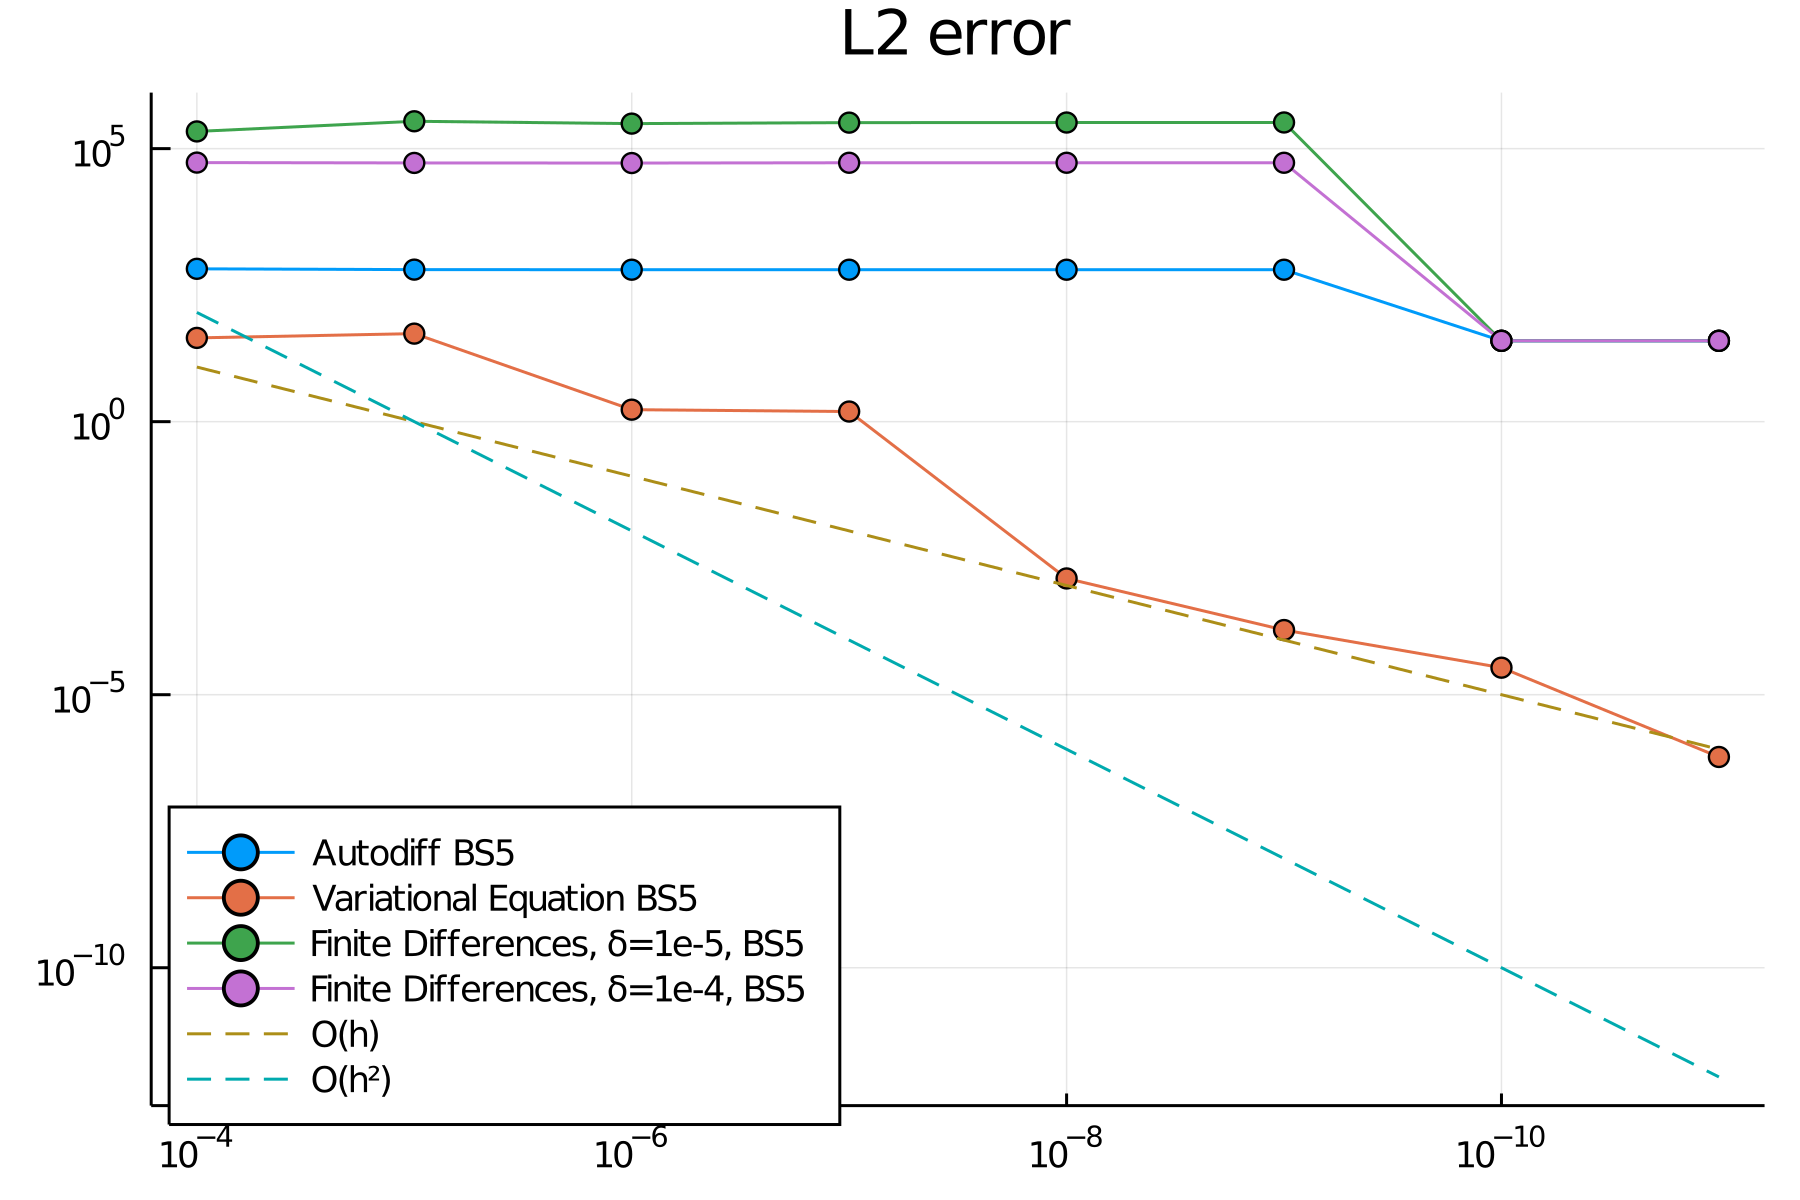

In [19]:
l2_plot = Plots.plot(tolerance_range,[l2_error(reference,tol_level) for tol_level in autodiff_BS5], 
    xaxis=:log, yaxis=:log, marker=:dot, xflip=true, label="Autodiff BS5",fmt=:png,dpi=300,title="L2 error")
Plots.plot!(tolerance_range,[l2_error(reference,tol_level) for tol_level in vareq_BS5], 
    marker=:dot, label="Variational Equation BS5", legend=(0.1,0.25))
Plots.plot!(tolerance_range,[l2_error(reference,tol_level) for tol_level in FD_1eminus5_BS5], 
    marker=:dot, label="Finite Differences, δ=1e-5, BS5")
Plots.plot!(tolerance_range,[l2_error(reference,tol_level) for tol_level in FD_1eminus4_BS5], 
    marker=:dot, label="Finite Differences, δ=1e-4, BS5")
#Plots.plot!(tolerance_range,[l2_error(reference,tol_level) for tol_level in FD_1eminus3_BS5], 
#    marker=:dot, label="Finite Differences, δ=1e-3, BS5")
Plots.plot!(tolerance_range,[1e5*x for x in tolerance_range], 
    linestyle=:dash,label="O(h)")
Plots.plot!(tolerance_range,[1e10*x*x for x in tolerance_range], 
    linestyle=:dash,label="O(h²)")

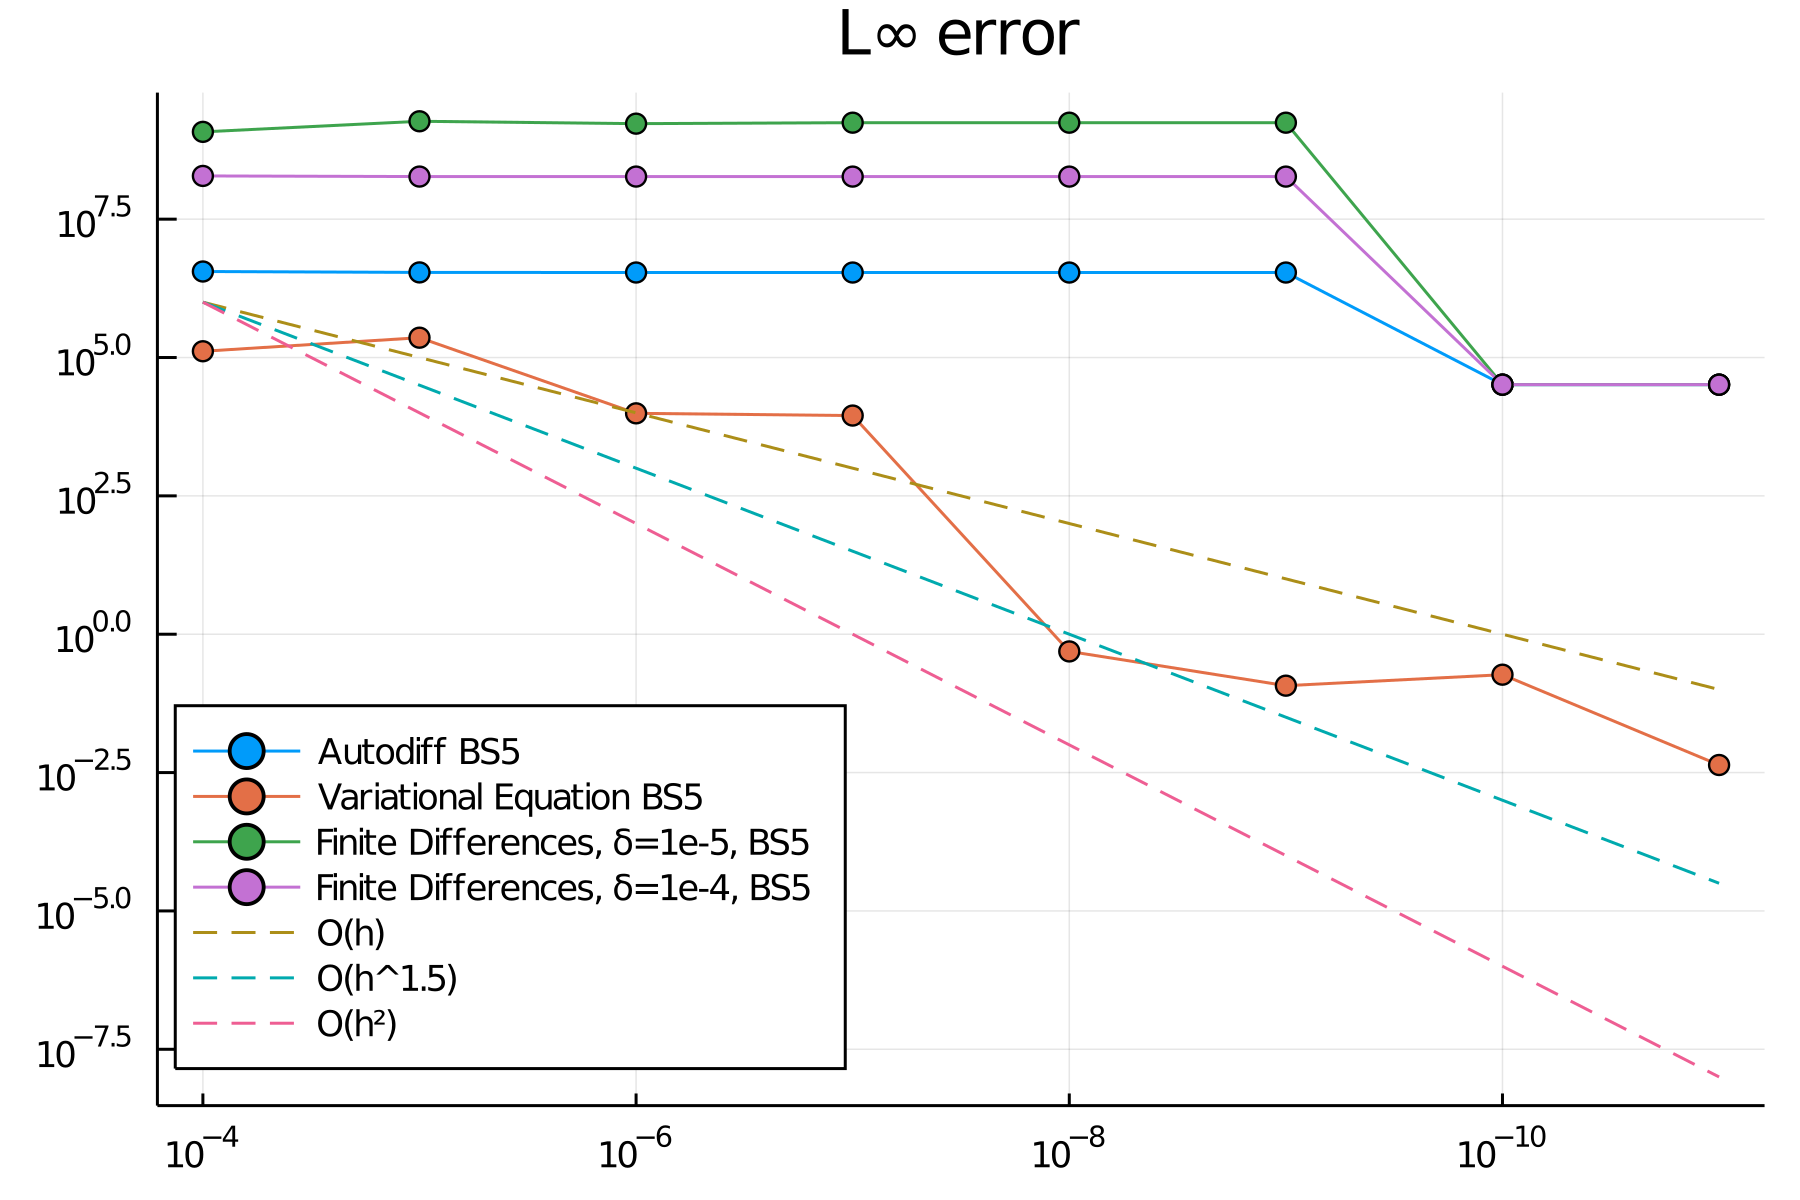

In [20]:
linf_plot = Plots.plot(tolerance_range,[linfty_error(reference,tol_level) for tol_level in autodiff_BS5], 
    xaxis=:log, yaxis=:log, marker=:dot, xflip=true, label="Autodiff BS5",fmt=:png,dpi=300,title="L∞ error")
Plots.plot!(tolerance_range,[linfty_error(reference,tol_level) for tol_level in vareq_BS5], 
    marker=:dot, label="Variational Equation BS5", legend=(0.1,0.35))
Plots.plot!(tolerance_range,[linfty_error(reference,tol_level) for tol_level in FD_1eminus5_BS5], 
    marker=:dot, label="Finite Differences, δ=1e-5, BS5")
Plots.plot!(tolerance_range,[linfty_error(reference,tol_level) for tol_level in FD_1eminus4_BS5], 
    marker=:dot, label="Finite Differences, δ=1e-4, BS5")
#Plots.plot!(tolerance_range,[linfty_error(reference,tol_level) for tol_level in FD_1eminus3_BS5], 
#    marker=:dot, label="Finite Differences, δ=1e-3, BS5")
Plots.plot!(tolerance_range,[1e10*x for x in tolerance_range], 
    linestyle=:dash,label="O(h)")
Plots.plot!(tolerance_range,[1e12*x*sqrt(x) for x in tolerance_range], 
    linestyle=:dash,label="O(h^1.5)")
Plots.plot!(tolerance_range,[1e14*x*x for x in tolerance_range], 
    linestyle=:dash,label="O(h²)")

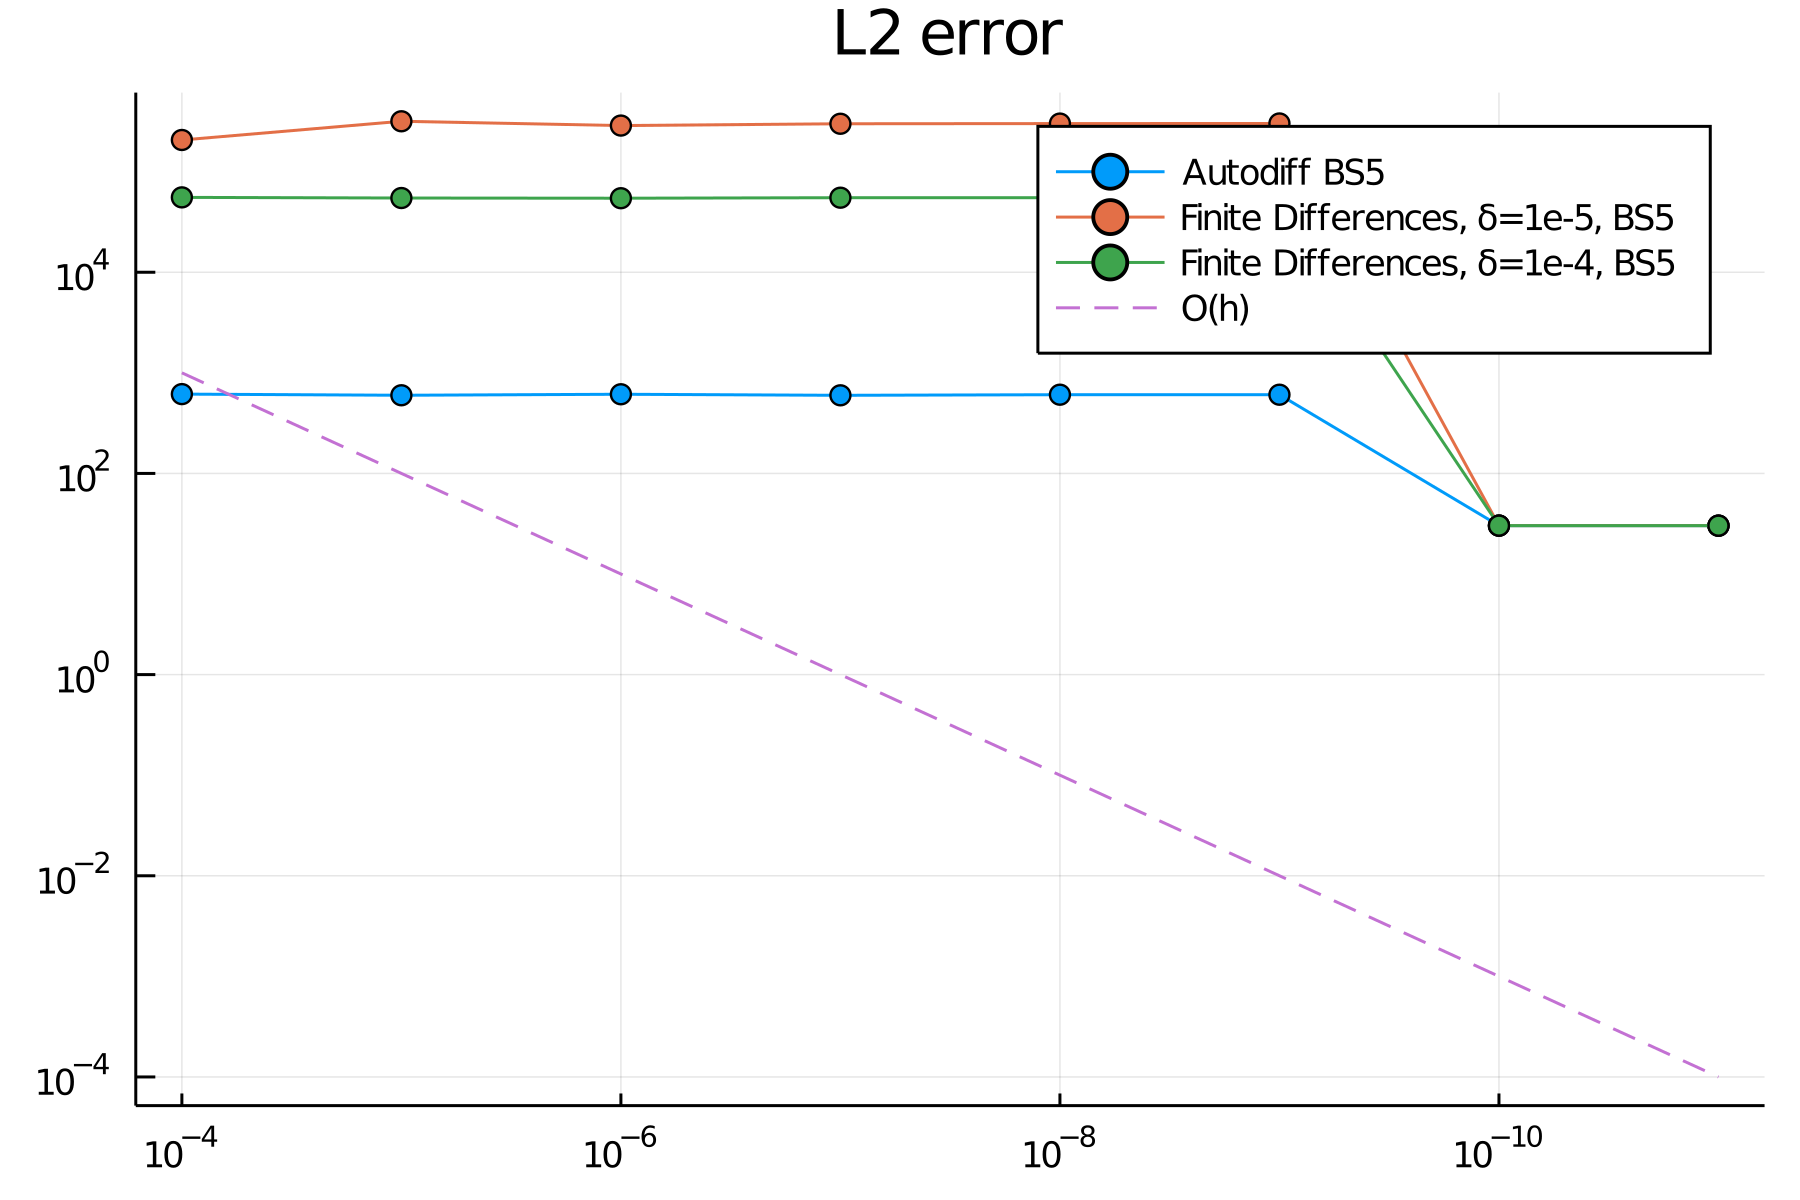

In [21]:
l2_plot_ref = Plots.plot(tolerance_range,[l2_error(reference_tol_level,tol_level) 
        for (reference_tol_level,tol_level) in zip(vareq_BS5,autodiff_BS5)], 
    xaxis=:log, yaxis=:log, marker=:dot, xflip=true, label="Autodiff BS5",fmt=:png,dpi=300,title="L2 error")
Plots.plot!(tolerance_range,[l2_error(reference_tol_level,tol_level) 
        for (reference_tol_level,tol_level) in zip(vareq_BS5,FD_1eminus5_BS5)], 
    marker=:dot, label="Finite Differences, δ=1e-5, BS5")
Plots.plot!(tolerance_range,[l2_error(reference_tol_level,tol_level) 
        for (reference_tol_level,tol_level) in zip(vareq_BS5,FD_1eminus4_BS5)], 
    marker=:dot, label="Finite Differences, δ=1e-4, BS5")
#Plots.plot!(tolerance_range,[l2_error(reference_tol_level,tol_level) 
#        for (reference_tol_level,tol_level) in zip(vareq_BS5,FD_1eminus3_BS5)], 
#    marker=:dot, label="Finite Differences, δ=1e-3, BS5")
Plots.plot!(tolerance_range,[1e7*x for x in tolerance_range], 
    linestyle=:dash,label="O(h)")

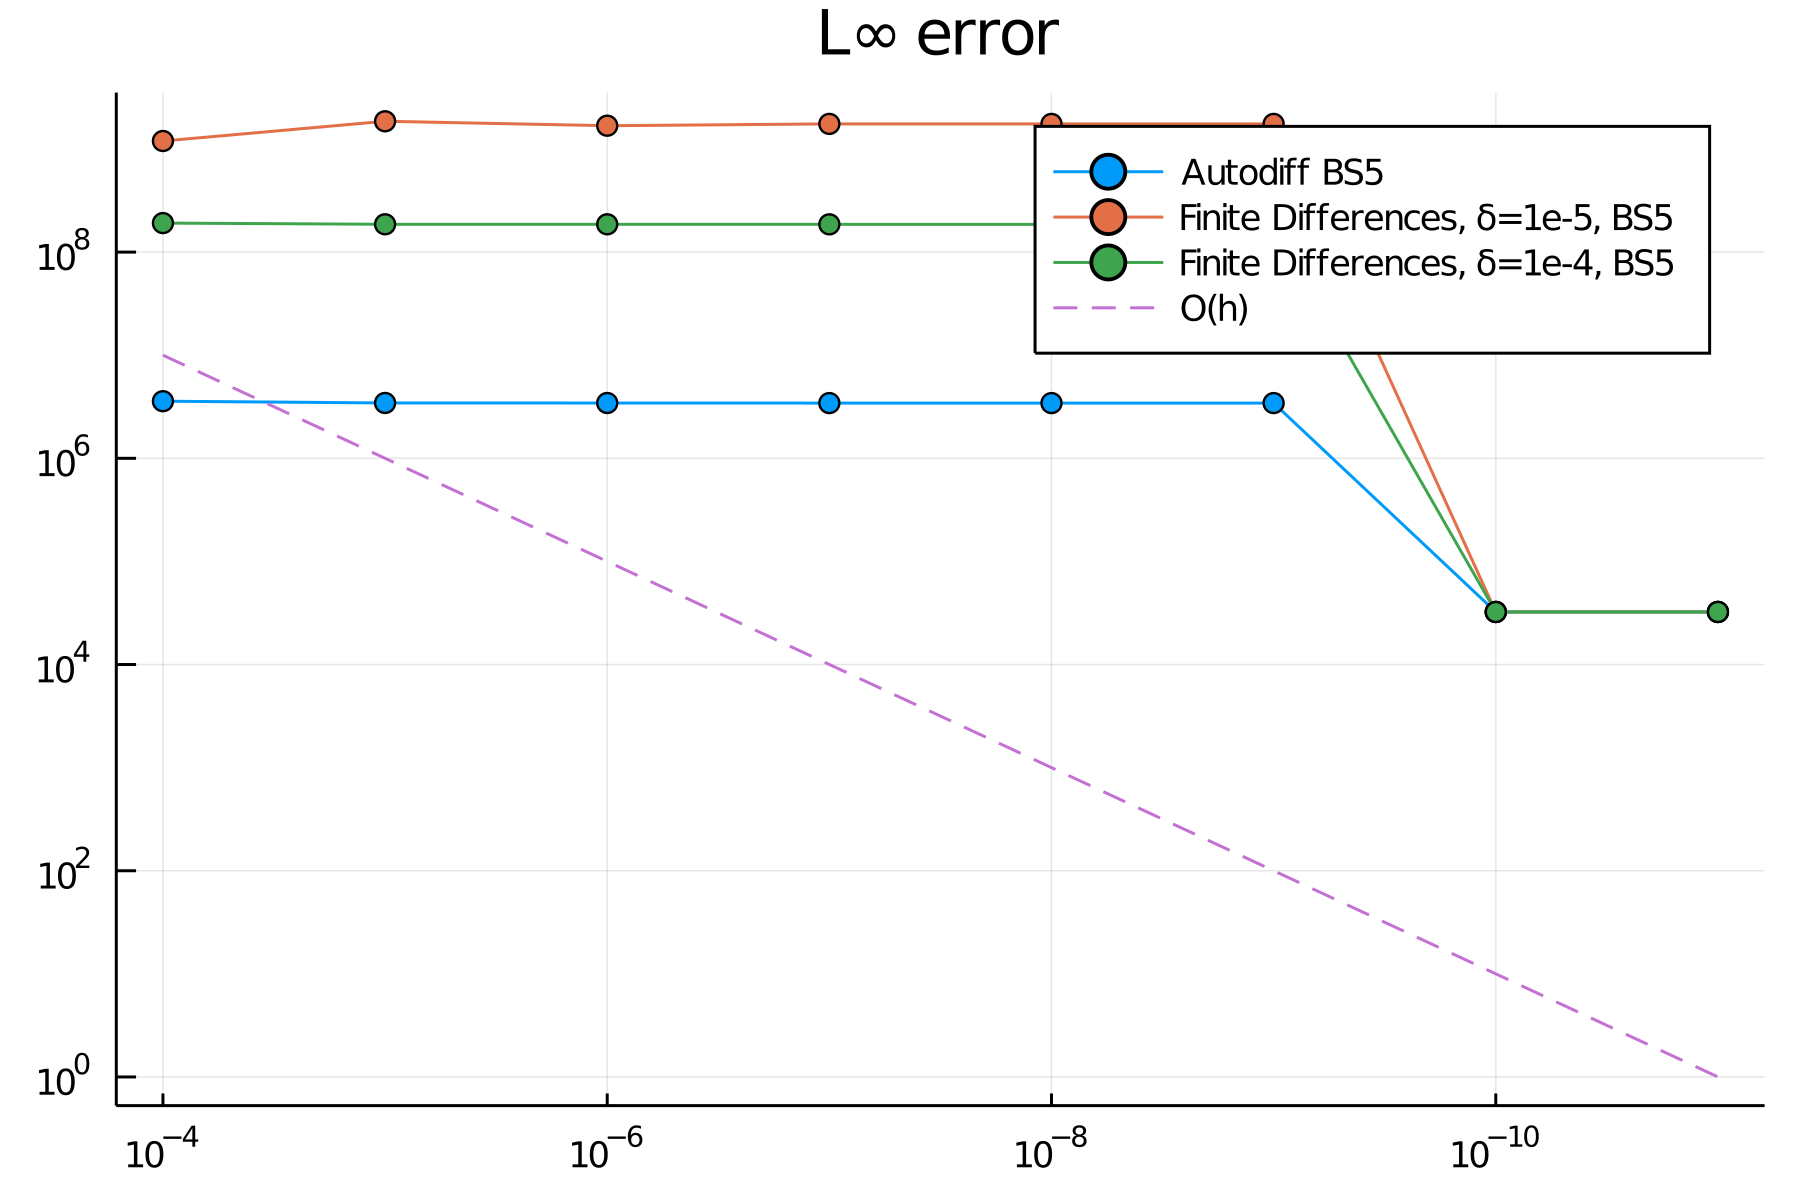

In [22]:
linf_plot_ref = Plots.plot(tolerance_range,[linfty_error(reference_tol_level,tol_level) 
        for (reference_tol_level,tol_level) in zip(vareq_BS5,autodiff_BS5)], 
    xaxis=:log, yaxis=:log, marker=:dot, xflip=true, label="Autodiff BS5",fmt=:png,dpi=300,title="L∞ error")
Plots.plot!(tolerance_range,[linfty_error(reference_tol_level,tol_level) 
        for (reference_tol_level,tol_level) in zip(vareq_BS5,FD_1eminus5_BS5)], 
    marker=:dot, label="Finite Differences, δ=1e-5, BS5")
Plots.plot!(tolerance_range,[linfty_error(reference_tol_level,tol_level) 
        for (reference_tol_level,tol_level) in zip(vareq_BS5,FD_1eminus4_BS5)], 
    marker=:dot, label="Finite Differences, δ=1e-4, BS5")
#Plots.plot!(tolerance_range,[linfty_error(reference_tol_level,tol_level) 
#        for (reference_tol_level,tol_level) in zip(vareq_BS5,FD_1eminus3_BS5)], 
#    marker=:dot, label="Finite Differences, δ=1e-3, BS5")
Plots.plot!(tolerance_range,[1e11*x for x in tolerance_range], 
    linestyle=:dash,label="O(h)")


In [23]:
tolerance_range_DP8 = [1e-5,1e-6,1e-7,1e-8,1e-9,1e-10,1e-11];

In [24]:
autodiff_DP8     = [evaluate_on_grid(Tdot_autodiff(OrdinaryDiffEq.DP8(),tol,0),ctx) 
    for tol in tolerance_range_DP8]
vareq_DP8       = [evaluate_on_grid(Tdot_vareq(OrdinaryDiffEq.DP8(),tol,0),ctx)    
    for tol in tolerance_range_DP8];

BoundsError: [91mBoundsError: attempt to access 165×105×14 scale(interpolate(OffsetArray(::Array{StaticArrays.SArray{Tuple{2},Float64,1,2},3}, 0:166, 0:106, 0:15), BSpline(Cubic(Free(OnGrid())))), (-12.0:0.25:29.0, -45.0:0.25:-19.0, 733010.0:7.0:733101.0)) with element type StaticArrays.SArray{Tuple{2},Float64,1,2} at index [Dual{ForwardDiff.Tag{Main.CoherentStructures.var"#543#544"{var"#17#18"{DP8,Float64}},Float64}}(7.792212797359125,2844.9333700890256,5019.2856863608695,48.12063115336697), Dual{ForwardDiff.Tag{Main.CoherentStructures.var"#543#544"{var"#17#18"{DP8,Float64}},Float64}}(-46.60770399618232,-1530.4376236177584,-2700.764392506851,-25.950584817492828), 733073.6991187363][39m

In [25]:
l2_plot = Plots.plot(tolerance_range_DP8,[l2_error(reference,tol_level) for tol_level in autodiff_DP8], 
    xaxis=:log, yaxis=:log, marker=:dot, xflip=true, label="Autodiff DP8",fmt=:png,dpi=300,title="L2 error")
Plots.plot!(tolerance_range_DP8,[l2_error(reference,tol_level) for tol_level in vareq_DP8], 
    marker=:dot, label="Variational Equation DP8", legend=(0.1,0.25))
Plots.plot!(tolerance_range_DP8,[1e7*x for x in tolerance_range_DP8], 
    linestyle=:dash,label="O(h)")
Plots.plot!(tolerance_range_DP8,[1e12*x*x for x in tolerance_range_DP8], 
    linestyle=:dash,label="O(h²)")

UndefVarError: [91mUndefVarError: autodiff_DP8 not defined[39m

In [26]:
linf_plot = Plots.plot(tolerance_range_DP8,[linfty_error(reference,tol_level) for tol_level in autodiff_DP8], 
    xaxis=:log, yaxis=:log, marker=:dot, xflip=true, label="Autodiff DP8",fmt=:png,dpi=300,title="L∞ error")
Plots.plot!(tolerance_range_DP8,[linfty_error(reference,tol_level) for tol_level in vareq_DP8], 
    marker=:dot, label="Variational Equation DP8", legend=(0.1,0.35))
Plots.plot!(tolerance_range_DP8,[1e10*x for x in tolerance_range_DP8], 
    linestyle=:dash,label="O(h)")
Plots.plot!(tolerance_range_DP8,[1e12*x*sqrt(x) for x in tolerance_range_DP8], 
    linestyle=:dash,label="O(h^1.5)")
Plots.plot!(tolerance_range_DP8,[1e14*x*x for x in tolerance_range_DP8], 
    linestyle=:dash,label="O(h²)")

UndefVarError: [91mUndefVarError: autodiff_DP8 not defined[39m

In [27]:
l2_plot_ref = Plots.plot(tolerance_range_DP8,[l2_error(reference_tol_level,tol_level) 
        for (reference_tol_level,tol_level) in zip(vareq_DP8,autodiff_DP8)], 
    xaxis=:log, yaxis=:log, marker=:dot, xflip=true, label="Autodiff DP8",fmt=:png,dpi=300,title="L2 error")
Plots.plot!(tolerance_range_DP8,[1e7*x for x in tolerance_range_DP8], 
    linestyle=:dash,label="O(h)")

UndefVarError: [91mUndefVarError: vareq_DP8 not defined[39m

In [28]:
linf_plot_ref = Plots.plot(tolerance_range_DP8,[linfty_error(reference_tol_level,tol_level) 
        for (reference_tol_level,tol_level) in zip(vareq_DP8,autodiff_DP8)], 
    xaxis=:log, yaxis=:log, marker=:dot, xflip=true, label="Autodiff DP8",fmt=:png,dpi=300,title="L∞ error")
Plots.plot!(tolerance_range_DP8,[1e11*x for x in tolerance_range_DP8], 
    linestyle=:dash,label="O(h)")

UndefVarError: [91mUndefVarError: vareq_DP8 not defined[39m

In [29]:
tolerance_range_VERN7 = [1e-4,1e-5,1e-6,1e-7,1e-8,1e-9,1e-10,1e-11];

In [30]:
autodiff_VERN7     = [evaluate_on_grid(Tdot_autodiff(OrdinaryDiffEq.Vern7(),tol,0),ctx) 
    for tol in tolerance_range_VERN7]
vareq_VERN7       = [evaluate_on_grid(Tdot_vareq(OrdinaryDiffEq.Vern7(),tol,0),ctx)    
    for tol in tolerance_range_VERN7];

┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Us

┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Us

┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Us

┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Us

┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Us

┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Us

┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Us

┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Us

┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Us

┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Us

┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Us

┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Us

┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Us

┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Us

┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Us

┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Us

┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Us

┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Us

┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Us

┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Us

┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Us

┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Us

┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Us

┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Us

┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Us

┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Us

┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Us

┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Us

┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Us

┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Us

┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Us

┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Us

┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Us

┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Us

┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Us

┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Us

┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Us

┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Us

┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Us

┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Us

┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Us

┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Us

┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Us

┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Us

┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Us

┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Us

┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Us

┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Us

┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Us

┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Us

Excessive output truncated after 524505 bytes.┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Martin\.julia\packages\SciMLBase\Afx1r\src\integrator_interface.jl:345
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the 

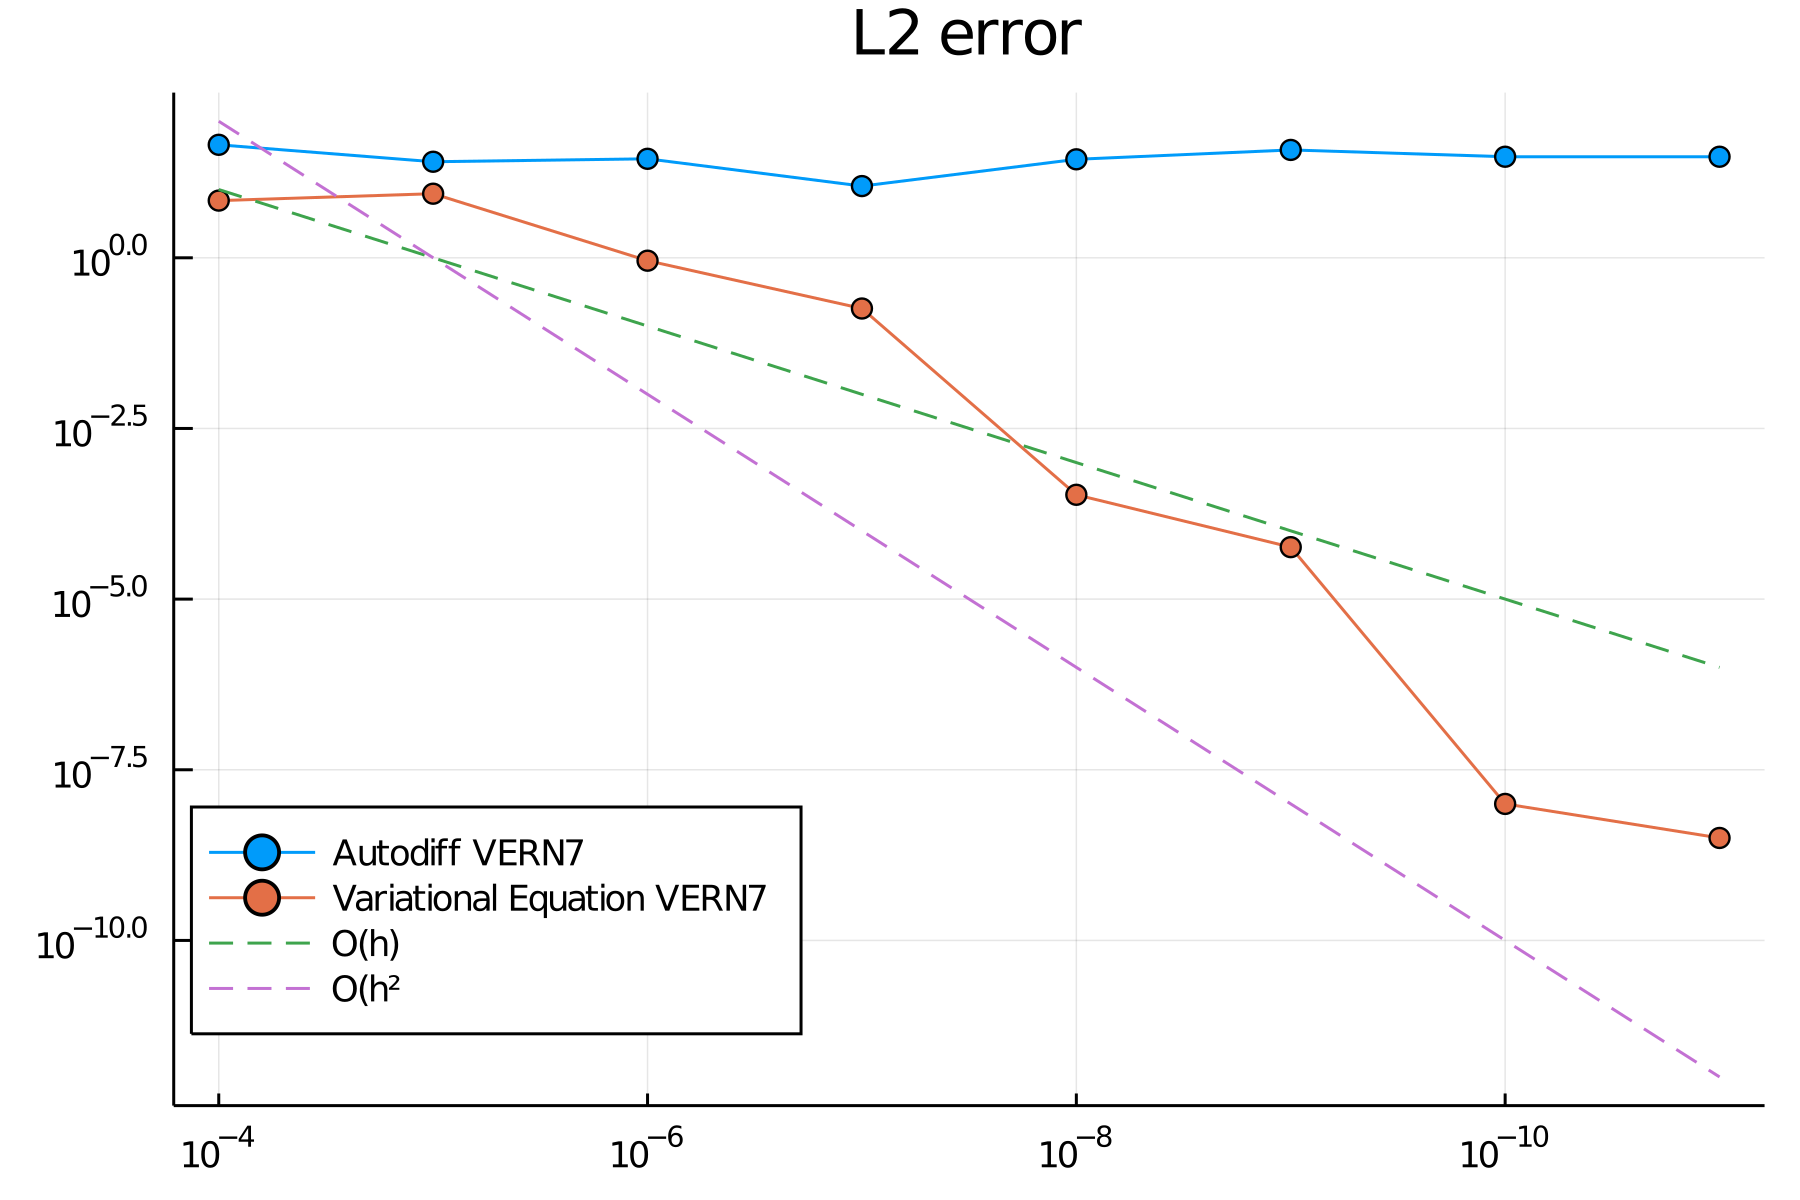

In [31]:
l2_plot = Plots.plot(tolerance_range_VERN7,[l2_error(reference,tol_level) for tol_level in autodiff_VERN7], 
    xaxis=:log, yaxis=:log, marker=:dot, xflip=true, label="Autodiff VERN7",fmt=:png,dpi=300,title="L2 error")
Plots.plot!(tolerance_range_VERN7,[l2_error(reference,tol_level) for tol_level in vareq_VERN7], 
    marker=:dot, label="Variational Equation VERN7", legend=(0.1,0.25))
Plots.plot!(tolerance_range_VERN7,[1e5*x for x in tolerance_range_VERN7], 
    linestyle=:dash,label="O(h)")
Plots.plot!(tolerance_range_VERN7,[1e10*x*x for x in tolerance_range_VERN7], 
    linestyle=:dash,label="O(h²")

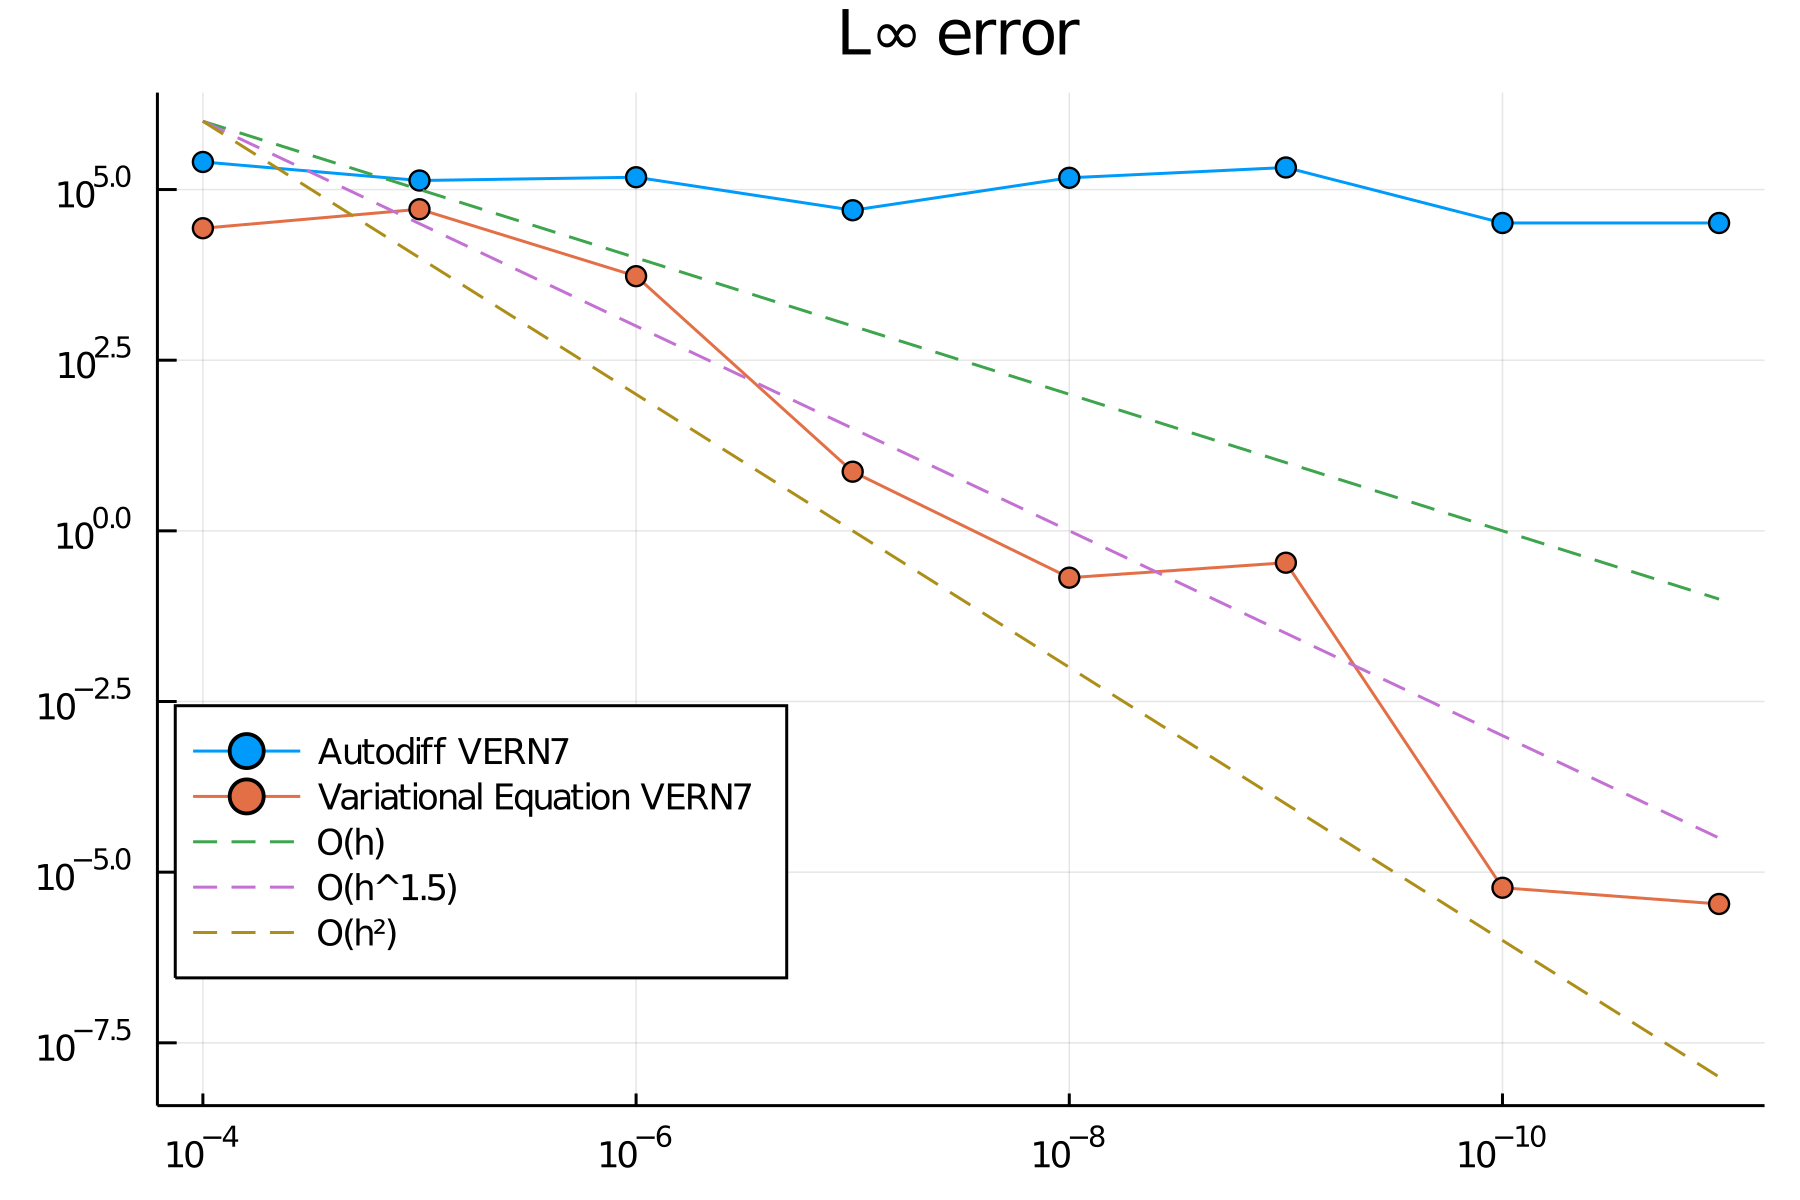

In [32]:
linf_plot = Plots.plot(tolerance_range,[linfty_error(reference,tol_level) for tol_level in autodiff_VERN7], 
    xaxis=:log, yaxis=:log, marker=:dot, xflip=true, label="Autodiff VERN7",fmt=:png,dpi=300,title="L∞ error")
Plots.plot!(tolerance_range,[linfty_error(reference,tol_level) for tol_level in vareq_VERN7], 
    marker=:dot, label="Variational Equation VERN7", legend=(0.1,0.35))
Plots.plot!(tolerance_range_VERN7,[1e10*x for x in tolerance_range_VERN7], 
    linestyle=:dash,label="O(h)")
Plots.plot!(tolerance_range_VERN7,[1e12*x*sqrt(x) for x in tolerance_range_VERN7], 
    linestyle=:dash,label="O(h^1.5)")
Plots.plot!(tolerance_range_VERN7,[1e14*x*x for x in tolerance_range_VERN7], 
    linestyle=:dash,label="O(h²)")

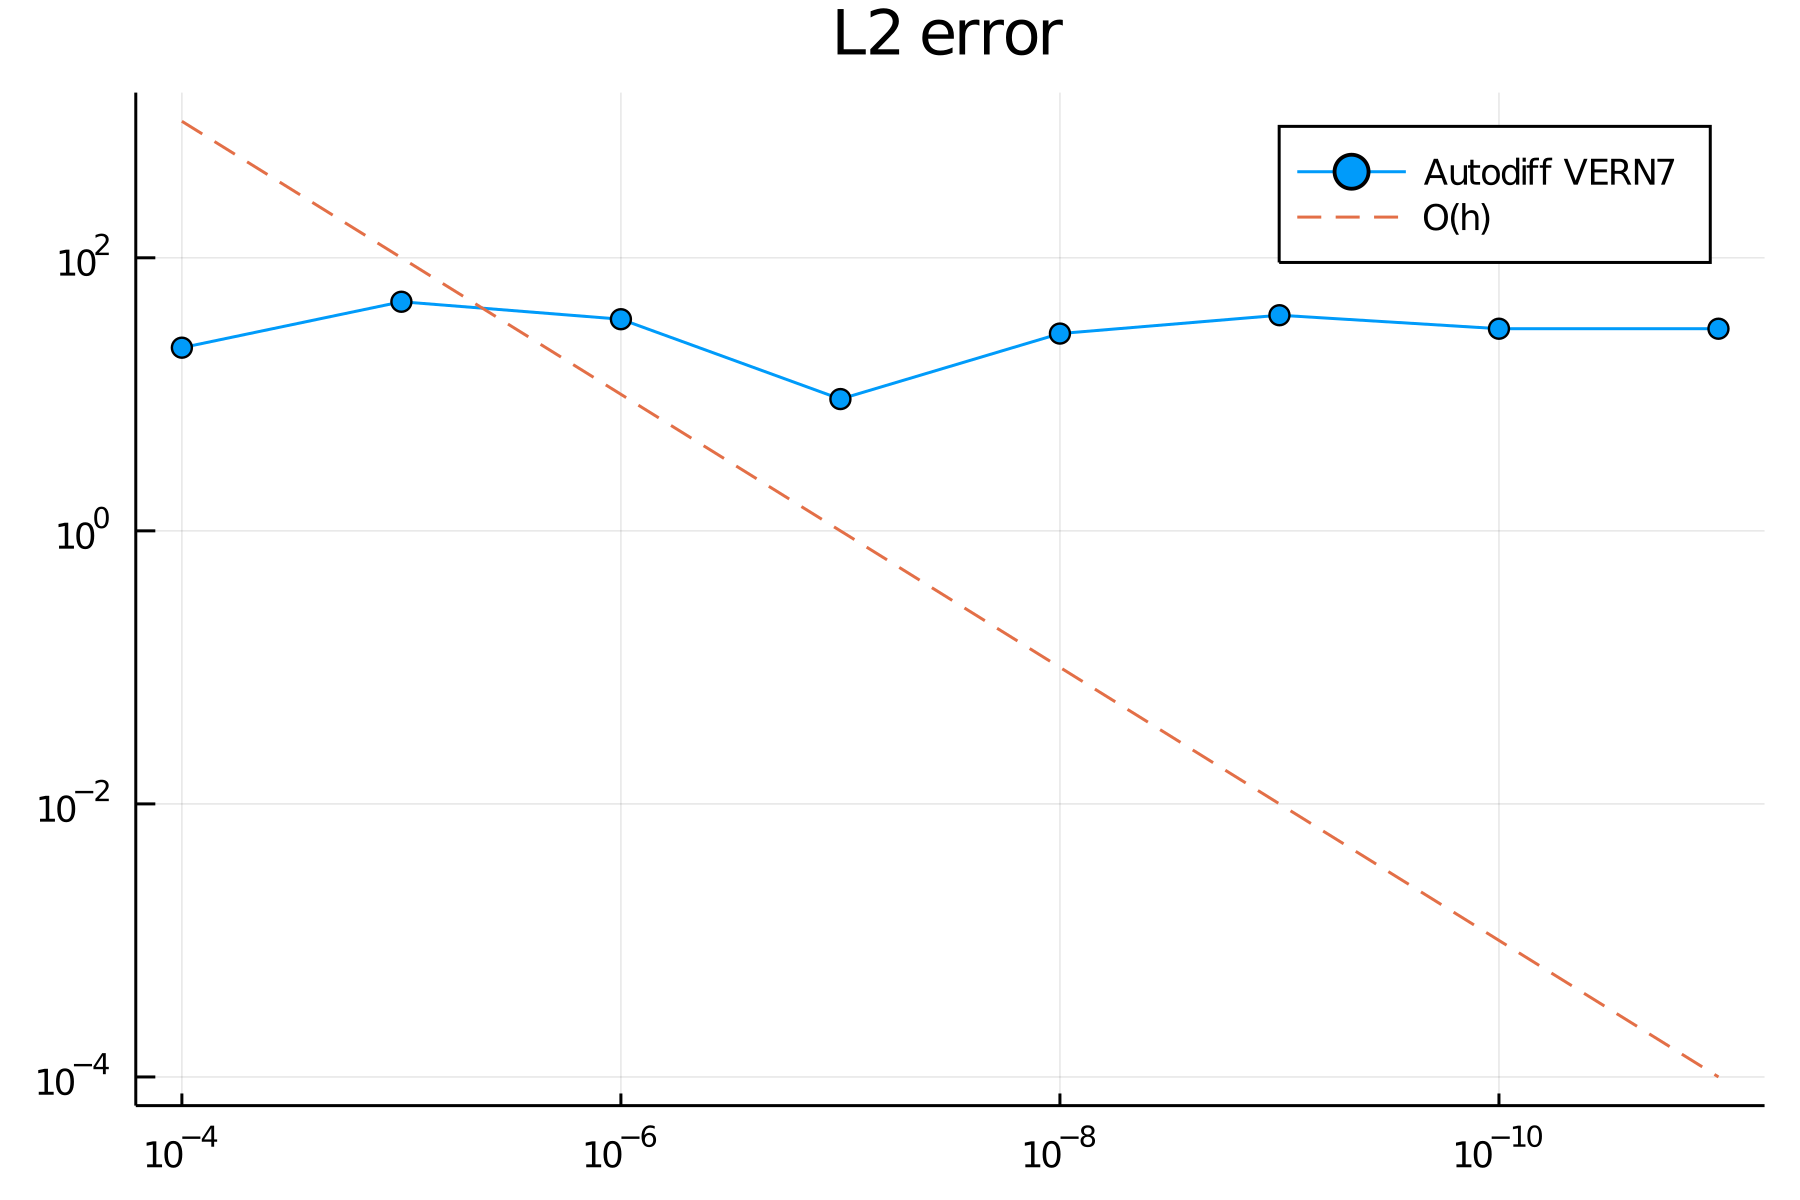

In [33]:
l2_plot_ref = Plots.plot(tolerance_range_VERN7,[l2_error(reference_tol_level,tol_level) 
        for (reference_tol_level,tol_level) in zip(vareq_VERN7,autodiff_VERN7)], 
    xaxis=:log, yaxis=:log, marker=:dot, xflip=true, label="Autodiff VERN7",fmt=:png,dpi=300,title="L2 error")
Plots.plot!(tolerance_range_VERN7,[1e7*x for x in tolerance_range_VERN7], 
    linestyle=:dash,label="O(h)")

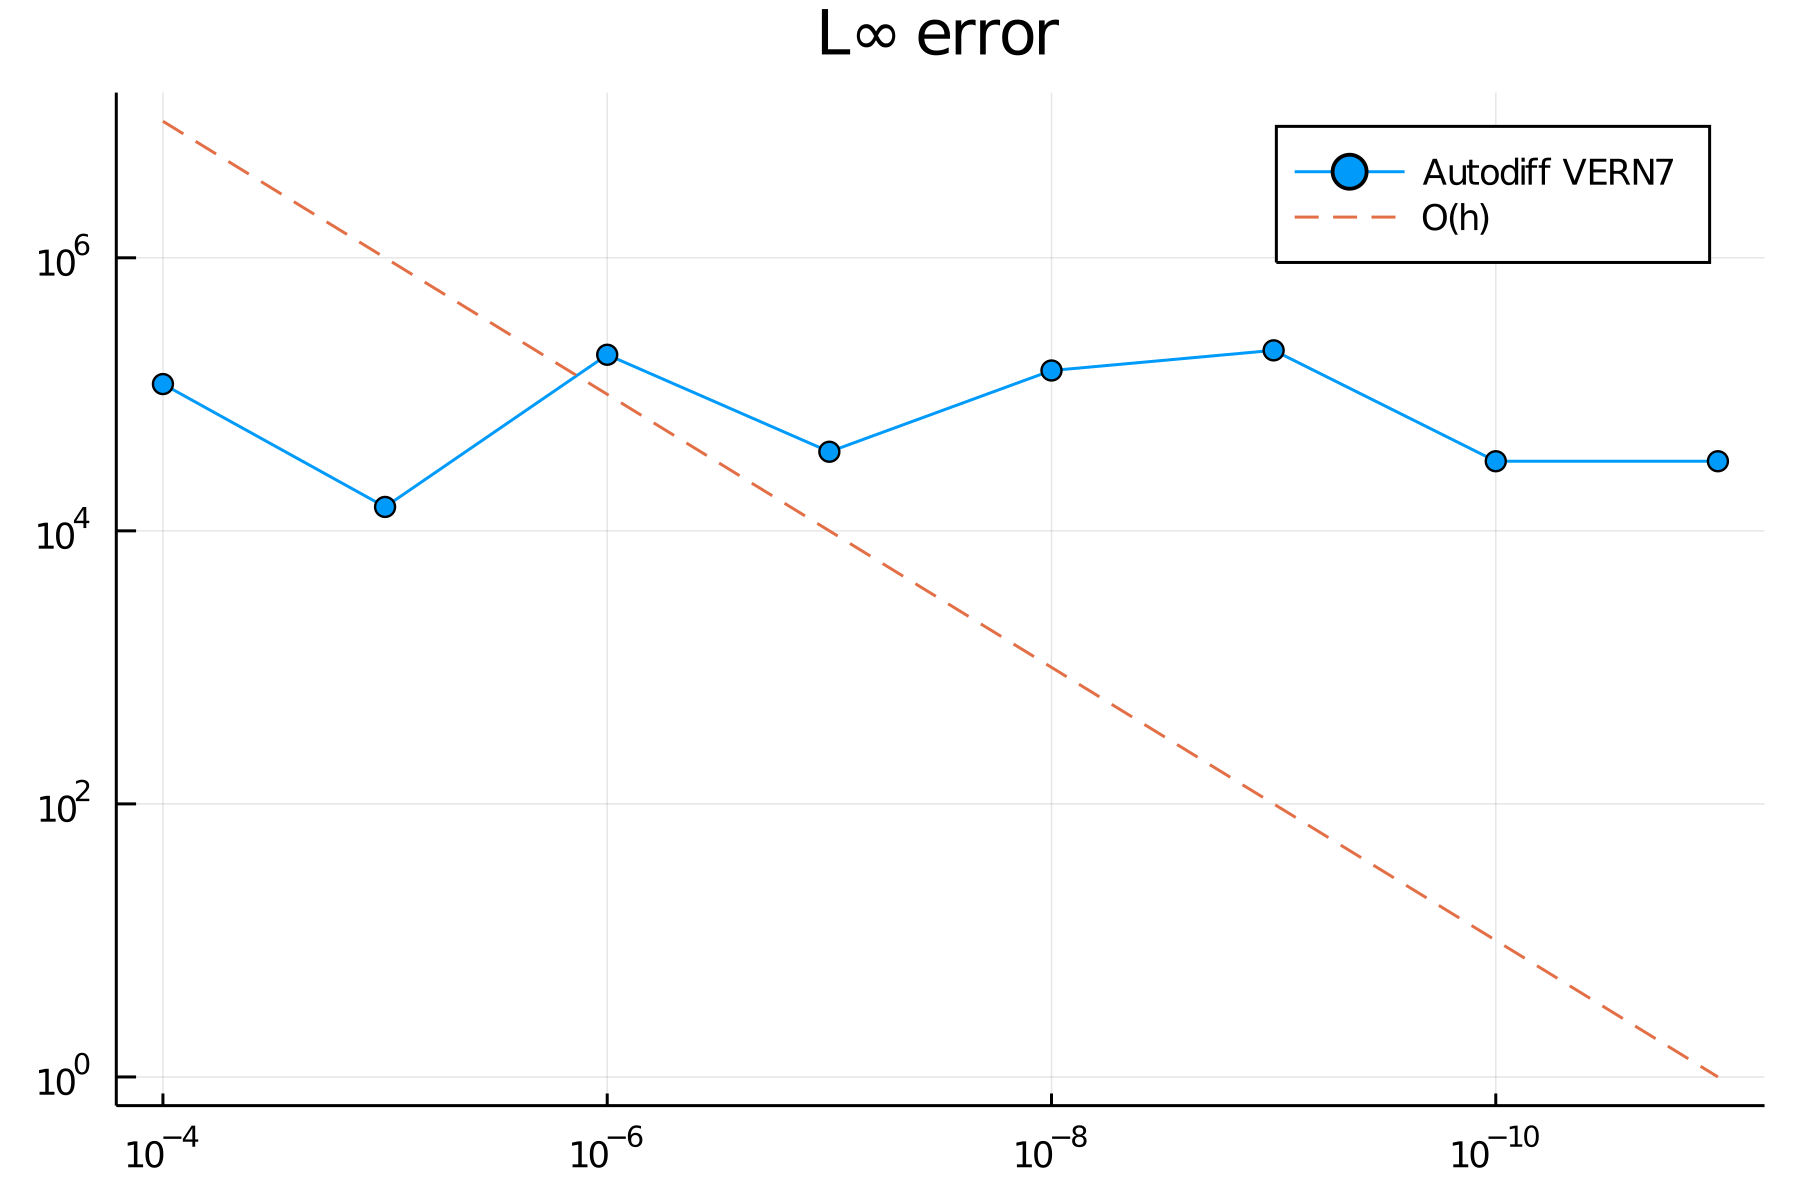

In [34]:
linf_plot_ref = Plots.plot(tolerance_range_VERN7,[linfty_error(reference_tol_level,tol_level) 
        for (reference_tol_level,tol_level) in zip(vareq_VERN7,autodiff_VERN7)], 
    xaxis=:log, yaxis=:log, marker=:dot, xflip=true, label="Autodiff VERN7",fmt=:png,dpi=300,title="L∞ error")
Plots.plot!(tolerance_range_VERN7,[1e11*x for x in tolerance_range_VERN7], 
    linestyle=:dash,label="O(h)")

In [35]:
overview_plot_l2 = Plots.plot(
    tolerance_range_DP8, [l2_error(reference,tol_level) for tol_level in autodiff_VERN7[2:end]], 
    color="blue", label="Autodiff VERN7",
        xaxis=:log, linewidth=2, yaxis=:log, xflip=true, fmt=:png,dpi=300,title="L2 error", legend=(0.1,0.45))
Plots.plot!(
    tolerance_range_DP8,[l2_error(reference,tol_level) for tol_level in vareq_VERN7[2:end]], 
    color="lightblue", label="Variational Equation VERN7")
Plots.plot!(
    tolerance_range_DP8,[l2_error(reference,tol_level) for tol_level in autodiff_BS5[2:end]], 
    color="red", linewidth=2, label="Autodiff Equation BS5")
Plots.plot!(
    tolerance_range_DP8,[l2_error(reference,tol_level) for tol_level in vareq_BS5[2:end]], 
    color="red", label="Variational Equation BS5")
Plots.plot!(
    tolerance_range_DP8,[l2_error(reference,tol_level) for tol_level in autodiff_DP8], 
    color="green", linewidth=2, label="Autodiff Equation DP8")
Plots.plot!(
    tolerance_range_DP8,[l2_error(reference,tol_level) for tol_level in vareq_DP8], 
    color="lightgreen", label="Variational Equation DP8")

Plots.plot!(
    tolerance_range_DP8,[1e6*x for x in tolerance_range_DP8], 
    color="lightgray", linestyle=:dash,label="O(h)")
Plots.plot!(
    tolerance_range_DP8,[1e8*x*sqrt(x) for x in tolerance_range_DP8], 
    color="lightgray", linestyle=:dashdot,label="O(h^(2.5))")
Plots.plot!(
    tolerance_range_DP8,[1e10*x*x for x in tolerance_range_DP8], 
    color="lightgray", linestyle=:dashdotdot,label="O(h²)")

Plots.plot!([1e-6],[l2_error(reference,autodiff_BS5[3])],marker=:dot,color="red",label=false)

UndefVarError: [91mUndefVarError: autodiff_DP8 not defined[39m

In [36]:
overview_plot_linfty = Plots.plot(
    tolerance_range_DP8, [linfty_error(reference,tol_level) for tol_level in autodiff_VERN7[2:end]], 
    color="blue", label="Autodiff VERN7",
        xaxis=:log, linewidth=2, yaxis=:log, xflip=true, fmt=:png,dpi=300,title="L∞ error", legend=(0.1,0.45))
Plots.plot!(
    tolerance_range_DP8,[linfty_error(reference,tol_level) for tol_level in vareq_VERN7[2:end]], 
    color="lightblue", label="Variational Equation VERN7")
Plots.plot!(
    tolerance_range_DP8,[linfty_error(reference,tol_level) for tol_level in autodiff_BS5[2:end]], 
    color="red", linewidth=2, label="Autodiff Equation BS5")
Plots.plot!(
    tolerance_range_DP8,[linfty_error(reference,tol_level) for tol_level in vareq_BS5[2:end]], 
    color="red", label="Variational Equation BS5")
Plots.plot!(
    tolerance_range_DP8,[linfty_error(reference,tol_level) for tol_level in autodiff_DP8], 
    color="green", linewidth=2, label="Autodiff Equation DP8")
Plots.plot!(
    tolerance_range_DP8,[linfty_error(reference,tol_level) for tol_level in vareq_DP8], 
    color="lightgreen", label="Variational Equation DP8")

Plots.plot!(
    tolerance_range_DP8,[1e10*x for x in tolerance_range_DP8], 
    color="lightgray", linestyle=:dash,label="O(h)")
Plots.plot!(
    tolerance_range_DP8,[1e12*x*sqrt(x) for x in tolerance_range_DP8], 
    color="lightgray", linestyle=:dashdot,label="O(h^(2.5))")
Plots.plot!(
    tolerance_range_DP8,[1e14*x*x for x in tolerance_range_DP8], 
    color="lightgray", linestyle=:dashdotdot,label="O(h²)")

Plots.plot!([1e-6],[linfty_error(reference,autodiff_BS5[3])],marker=:dot,color="red",label=false)

UndefVarError: [91mUndefVarError: autodiff_DP8 not defined[39m

scale = 1e-1
x_s = [node.x[1] for node in ctx.grid.nodes]
y_s = [node.x[2] for node in ctx.grid.nodes]

reference_x = [max(-10,min(10,v[1])) for v in reference]
reference_y = [max(-10,min(10,v[2])) for v in reference]

quiver(x_s,y_s,quiver=(reference_x.*scale,reference_y.*scale))

solve(prob,alg,adaptive=false,dt=x)